In [1]:
# Change the dataset in global_vars.py to KORA.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None # ['KORA2460830', 'KORA2460249']
exclude = ['KORA2460249']

%load_ext autoreload
%autoreload 2

In [2]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_kora_file_paths()
file_paths

{'KORA2456289': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz'],
   'F': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_1.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_2.nii.gz'],
   'W': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2456289/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_3.nii.gz',
    '/home/abhijit/nas_driv

In [3]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [4]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [5]:
# # TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

# for vol in file_paths.keys():
#     if one_time_n4_optimization:
#         break
#     print(f'applying n4 bias field on opp scans of {vol}...')
#     vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
#     idx = 0
#     file_paths[vol]['N4_1'] = []
#     for opp_img, bias_field_img, opp_file in vol_parts:
#         file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
#         idx+=1

In [6]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched_resampled = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched_resampled, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

started with KORA2456289...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         235.26948547]
 [  0.           0.          -1.69999695 144.93167114]
 [  0.          -1.70138884   0.         -21.65872765]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          230.26948547]
 [   0.            0.           -1.69999695  144.93167114]
 [   0.           -1.66666663    0.         -256.65872192]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2456289
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         235.26948547]
 [  0.           0.          -1.69999695 144.93167114]
 [  0.        

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          240.02130127]
 [   0.            0.           -1.69999695  119.15551758]
 [   0.           -1.66666663    0.         -215.20669556]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2452879
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         245.02130127]
 [  0.           0.          -1.69999695 119.15551758]
 [  0.          -1.70138884   0.          19.79330063]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          240.02130127]
 [   0.            0.           -1.69999695  119.15551758]
 [   0.           

Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453229
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         262.03250122]
 [  0.           0.          -1.69999695 152.1910553 ]
 [  0.          -1.70138884   0.           0.52120578]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          257.03250122]
 [   0.            0.           -1.69999695  152.1910553 ]
 [   0.           -1.66666663    0.         -234.47879028]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453229
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.      

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          240.01109314]
 [   0.            0.           -1.69999695  116.75502014]
 [   0.           -1.66666663    0.         -283.12890625]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453290
started with KORA2460734...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         242.58334351]
 [  0.           0.          -1.69999695 140.065979  ]
 [  0.          -1.70138884   0.          -9.54386711]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          237.58334351]
 [   0.            0.           -1.69999695  14

Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2459745
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         249.87677002]
 [  0.           0.          -1.70001221 138.57743835]
 [  0.          -1.70138884   0.         -13.95329475]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          244.87678528]
 [   0.            0.           -1.70001221  138.57743835]
 [   0.           -1.66666663    0.         -248.95329285]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2459745
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.       

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          235.15220642]
 [   0.            0.           -1.69999695  121.61049652]
 [   0.           -1.66666663    0.         -241.47940063]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2462405
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         240.15220642]
 [  0.           0.          -1.69999695 121.61049652]
 [  0.          -1.70138884   0.          -6.47939968]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          235.15220642]
 [   0.            0.           -1.69999695  121.61049652]
 [   0.          

Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453666
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         240.15220642]
 [  0.           0.          -1.69999695 149.71565247]
 [  0.          -1.70138884   0.         -11.6140852 ]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          235.15220642]
 [   0.            0.           -1.69999695  149.71565247]
 [   0.           -1.66666663    0.         -246.61408997]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453666
started with KORA2462026...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.701

In [7]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with KORA2456289...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -253.02911377]
 [   0.            2.            0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)
Transforming Images to RAS.....
-72.0108871459961
neagtive value detected
saving directory: temp/KORA/n4_corrected_2/vol/KORA2456289
n4 processing part-2 started with KORA2459728...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -228.67341614]
 [   0.            2.            0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)
Transforming Images to RAS.....
-76.17095184326172
neagtive value detected
saving directory: temp/KORA/n4_corrected_2/vol/KORA2459728

Transforming Images to RAS.....
-78.44667053222656
neagtive value detected
saving directory: temp/KORA/n4_corrected_2/vol/KORA2462026
n4 processing part-2 started with KORA2453363...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -253.53926086]
 [   0.            2.            0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)
Transforming Images to RAS.....
-85.8489761352539
neagtive value detected
saving directory: temp/KORA/n4_corrected_2/vol/KORA2453363


In [8]:
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    in_file = n4_dict[vol]['N4_2']['SCALED']
    opp_file = file_paths[vol]['ONE']['OPP']
    new_filename = opp_file.split('/')[-1].split('.')[0]
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

n4-biasfield-correction starting with KORA2456289...
done
n4-biasfield-correction starting with KORA2459728...
done
n4-biasfield-correction starting with KORA2452879...
done
n4-biasfield-correction starting with KORA2453578...
done
n4-biasfield-correction starting with KORA2459908...
done
n4-biasfield-correction starting with KORA2453229...
done
n4-biasfield-correction starting with KORA2456120...
done
n4-biasfield-correction starting with KORA2453290...
done
n4-biasfield-correction starting with KORA2460734...
done
n4-biasfield-correction starting with KORA2460830...
done
n4-biasfield-correction starting with KORA2459745...
done
n4-biasfield-correction starting with KORA2460408...
done
n4-biasfield-correction starting with KORA2458366...
done
n4-biasfield-correction starting with KORA2462405...
done
n4-biasfield-correction starting with KORA2460723...
done
n4-biasfield-correction starting with KORA2453666...
done
n4-biasfield-correction starting with KORA2462026...
done
n4-biasfield-c

In [9]:
# # TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
# for vol in file_paths.keys():
#     if vol_to_check_list is not None and vol not in vol_to_check_list:
#         continue
#     print(f'applying n4 bias field on stitched opp scans of {vol}...')

#     opp_file = file_paths[vol]['ONE']['OPP']
#     n4_counterpart = n4_dict[vol]['N4_2']
#     print(opp_file, n4_counterpart['IN_BIAS'])
#     opp_img = read_ras(opp_file)
#     bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

#     file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [10]:
def kora_vol_label_fix(vol, label, use_alternate_approach=False):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))

    ld = label.get_fdata()
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, 0:sz+ez] = ld
    else:
        final_label[0:sx+ex, 0:sy+ey, 77:77+76] = ld[:, :, :76]
        
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=2)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    
    return vol, final_label_img

def kora_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
        
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
KORA2456289
['datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-22.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-5.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-22.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to 

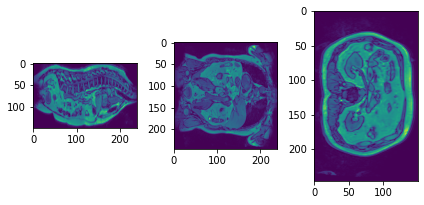

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


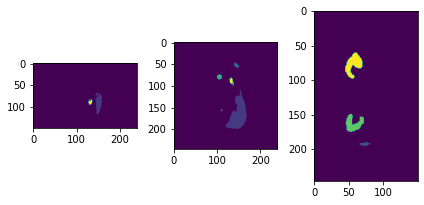

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459728
['datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-6.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Readin

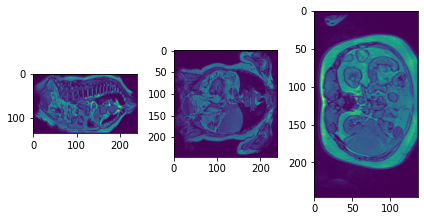

Affine:[[   2.            0.           -0.         -228.67341614]
 [   0.            2.           -0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


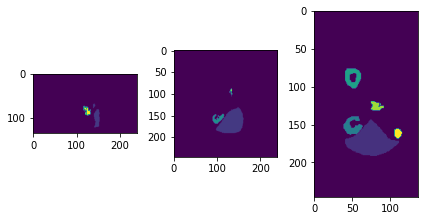

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2452879
['datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2452879/Combi', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caip

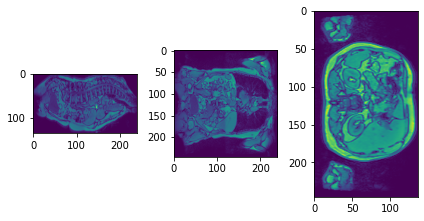

Affine:[[   2.            0.           -0.         -243.27729797]
 [   0.            2.           -0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


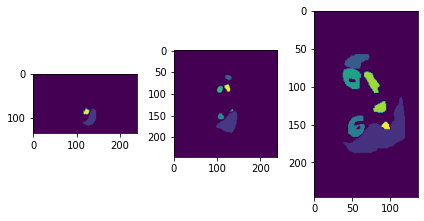

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453578
['datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453578/Combi', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_

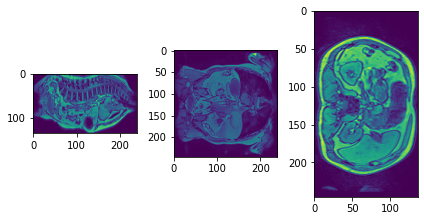

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


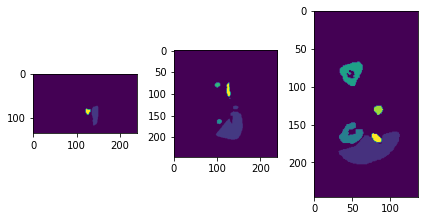

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459908
['datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (right) .nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (left)

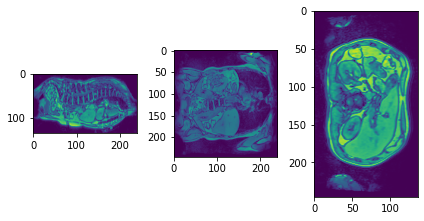

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


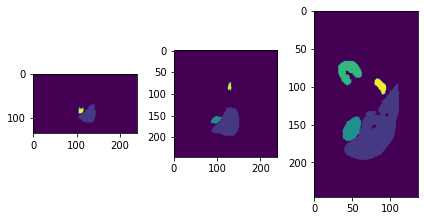

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453229
['datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_is

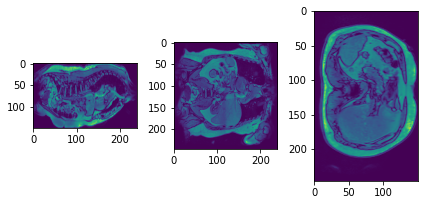

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


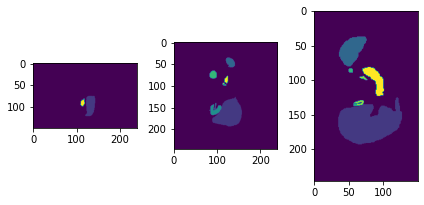

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2456120
['datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2456120/Combi', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-21.nrrd_Adrenal galnd(right).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-21.nrrd_adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe

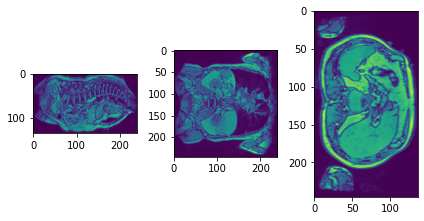

Affine:[[   2.            0.           -0.         -250.58435059]
 [   0.            2.           -0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


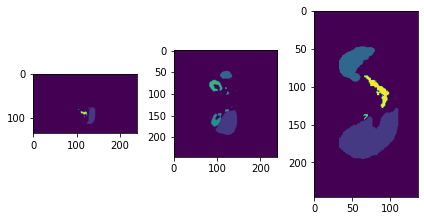

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453290
['datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Pancreas.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....

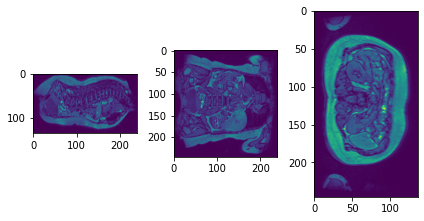

Affine:[[   2.            0.           -0.         -243.28752136]
 [   0.            2.           -0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


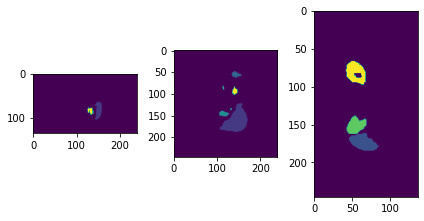

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460734
['datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-4.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-7_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-7.nrrd_Adrenal gland(right).nrr

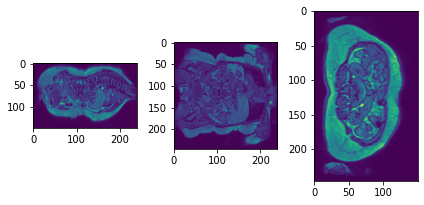

Affine:[[   2.            0.           -0.         -245.71525574]
 [   0.            2.           -0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


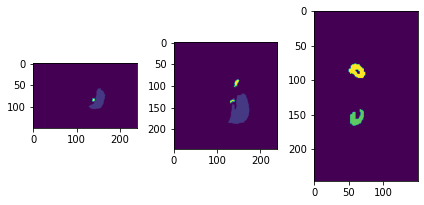

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460830
['datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_10_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9-4.nrrd_Adrenal gland(left).n

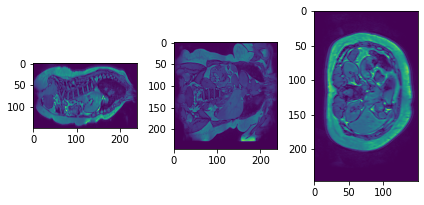

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


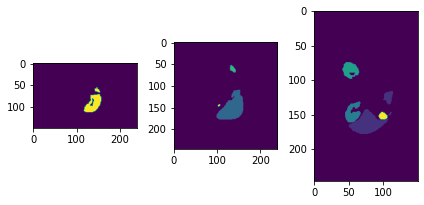

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459745
['datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-24.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-24.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-20.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8

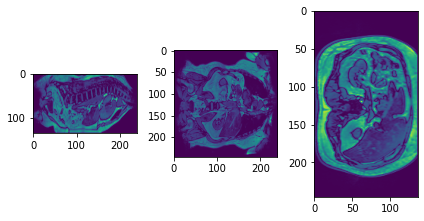

Affine:[[   2.            0.           -0.         -238.42182922]
 [   0.            2.           -0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


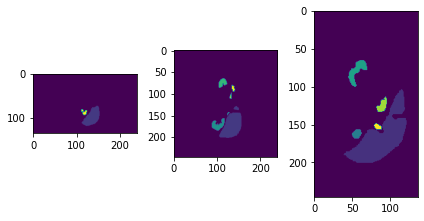

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460408
['datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney(left).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney(right).nrrd']
Readi

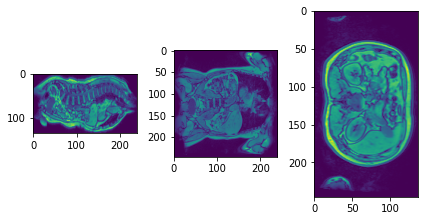

Affine:[[   2.            0.           -0.         -243.29772949]
 [   0.            2.           -0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


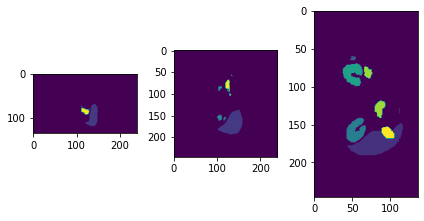

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2458366
['datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-18.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (R

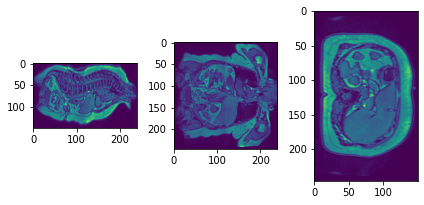

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


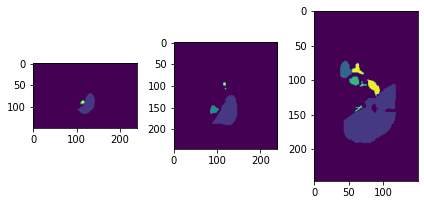

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2462405
['datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Spleen.nrrd']
Rea

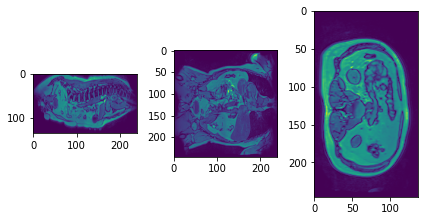

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


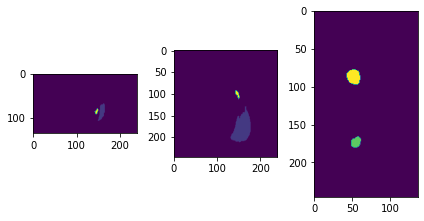

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460723
['datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-25.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-26.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney(

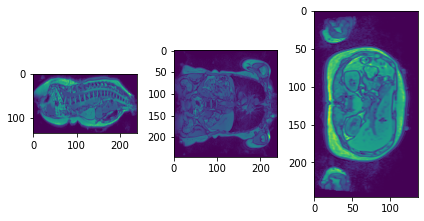

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


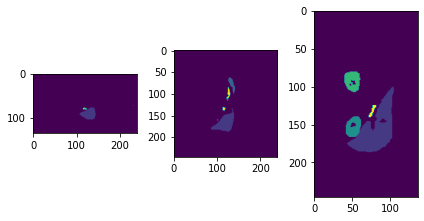

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453666
['datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Kidney (right)-4.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Kidney (left)-3.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(left

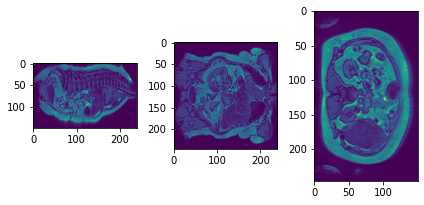

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


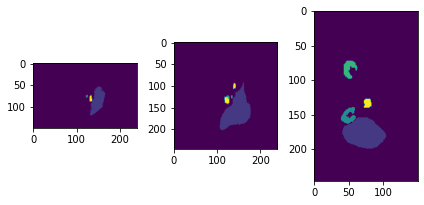

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2462026
['datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (left)-2.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (right)-3.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_op

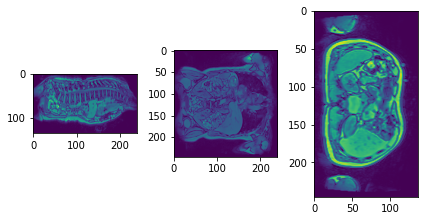

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


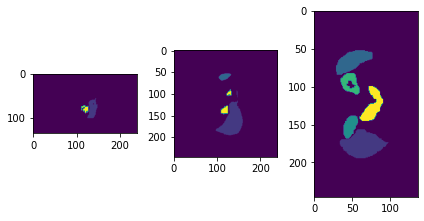

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453363
['datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd', 'datasets/lablmaps/KORA/KORA2453363/Combi', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder-2.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363

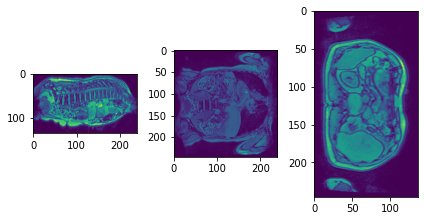

Affine:[[   2.            0.           -0.         -253.53926086]
 [   0.            2.           -0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


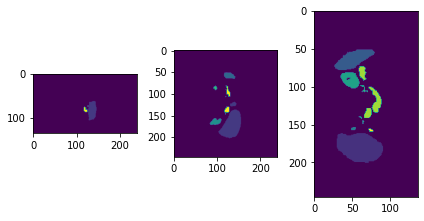

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
FINISHED.


In [11]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     ref_vol = nb.load(file_paths[vol]['ONE_ORIG']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        if labelname in ['PANCREAS']:
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = kora_label_parts(img_ras_list)
    s_label = resample_to_output(s_label, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    
    if vol == 'KORA2460249':
        volume, s_label = kora_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = kora_vol_label_fix(volume, s_label)
        
    volume = hist_match(volume)
    
    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')